In [ ]:
#import necessary python libraries
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [ ]:
def load_data(data_path):
  dataset = pd.read_csv(
      filepath_or_buffer = data_path,
      delimiter = ';'
  )
  dataset.columns = dataset.columns.str.lower()
  dataset.index= pd.to_datetime(dataset['timestamp'].tolist(),unit = 's', origin='unix')
  dataset.set_index('timestamp')
  return dataset

In [ ]:
hourly_data = load_data("/content/combined_hourly_data.csv")

In [ ]:
sensor_data = load_data("/content/sensors_data.csv")

In [ ]:
weather_data = load_data("/content/weather_data.csv")

In [ ]:
sensor_data.resample('1T').mean()
sensor_data

In [ ]:
hourly_data.info()

In [ ]:
print("Rows     :",hourly_data.shape[0])
print("Columns  :",hourly_data.shape[1])
print("\nMissing Values: ",hourly_data.isnull().any())
print("\nTotal missing Values: ",hourly_data.isna().sum())

In [ ]:
hourly_data.describe()

In [ ]:
rssi1 = hourly_data['rssi_01']
rssi2 = hourly_data['rssi_02']
rssi3 = hourly_data['rssi_03']
rssi4 = hourly_data['rssi_04']
rssi5 = hourly_data['rssi_05']
rssi6 = hourly_data['rssi_06']
rssi7 = hourly_data['rssi_07']

In [ ]:
rssi1.plot(grid=True)

In [ ]:
import plotly.express as px
fig = px.line(rssi1,x=rssi1.index,y='rssi_01')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [ ]:
df_input= hourly_data[['temp','hum','bar','rain','rssi_01']]

In [ ]:
df_input.plot(subplots=True)

In [ ]:
df_input.hist()

In [ ]:
from pandas.plotting import lag_plot
lag_plot(rssi1,lag=1)

In [ ]:
lag_plot(df_input['temp'],lag = 1)

In [ ]:
lag_plot(df_input['hum'],lag=1)

In [ ]:
lag_plot(df_input['bar'],lag=1)

In [ ]:
lag_plot(df_input['rain'],lag=1)

In [ ]:
sns.pairplot(hourly_data[['temp','hum','bar','rain','rssi_05']])

In [ ]:
corr = hourly_data[['temp','hum','bar','rain','rssi_01']].corr(method='pearson')
corr

In [ ]:
#scaling the dataset
df_input = hourly_data[['temp','hum','bar','rain','rssi_01']]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)

In [ ]:
features1 = data_scaled[:,-1]
target1 = data_scaled[:,4]

In [ ]:
features = data_scaled
target = data_scaled[:,4]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=123, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size = 0.2, random_state=123, shuffle=False)

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(features1, target1, test_size = 0.2, random_state=123, shuffle=False)
x_train1, x_val1, y_train1, y_val1 = train_test_split(x_train1, y_train1, test_size = 0.2, random_state = 123, shuffle = False)

In [ ]:
window_length = 5
batch_size = 32
num_features = 5
num_features1 = 1
train_generator = TimeseriesGenerator(x_train,y_train, length=window_length,sampling_rate=1,batch_size=batch_size)
val_generator = TimeseriesGenerator(x_val,y_val,length=window_length,sampling_rate=1,batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test,y_test, length=window_length, sampling_rate=1, batch_size=batch_size)

In [ ]:
train_generator1 = TimeseriesGenerator(x_train1,y_train1, length=window_length,sampling_rate=1,batch_size=batch_size)
val_generator1 = TimeseriesGenerator(x_val1,y_val1,length=window_length,sampling_rate=1,batch_size=batch_size)
test_generator1 = TimeseriesGenerator(x_test1,y_test1, length=window_length, sampling_rate=1, batch_size=batch_size)

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128,input_shape=(window_length, num_features),return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [ ]:
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.LSTM(128,input_shape=(window_length, num_features1),return_sequences=True))
model1.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model1.add(tf.keras.layers.LSTM(128, return_sequences=True))
model1.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model1.add(tf.keras.layers.Dropout(0.3))
model1.add(tf.keras.layers.LSTM(64, return_sequences=False))
model1.add(tf.keras.layers.Dropout(0.3))
model1.add(tf.keras.layers.Dense(1))

In [ ]:
model.summary()

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min')
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit_generator(train_generator, epochs=100,
                              validation_data=val_generator,
                              shuffle=False,
                              callbacks=[early_stopping])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min')
model1.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history1 = model1.fit_generator(train_generator1, epochs=100,
                              validation_data=val_generator1,
                              shuffle=False,
                              callbacks=[early_stopping])

In [ ]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.legend()
plt.savefig('Training_vs_Valid_climate.png')

In [ ]:
plt.plot(history1.history['loss'],label='Training Loss')
plt.plot(history1.history['val_loss'],label='Validation loss')
plt.legend()
plt.savefig('Training_vs_Valid.png')

In [ ]:
model.evaluate_generator(test_generator, verbose=0)

In [ ]:
model1.evaluate_generator(test_generator1, verbose=0)

In [ ]:
predictions=model.predict_generator(test_generator)

In [ ]:
predictions1 = model1.predict_generator(test_generator1)

In [ ]:
df_pred = pd.concat([pd.DataFrame(x_test[:,:-1][window_length:]),pd.DataFrame(predictions)],axis=1)

In [ ]:
df_pred1 = pd.concat([pd.DataFrame(x_test[:,:-1][window_length:]),pd.DataFrame(predictions1)],axis=1)

In [ ]:
reverse_trans = scaler.inverse_transform(df_pred)

In [ ]:
reverse_trans1 = scaler.inverse_transform(df_pred1)

In [ ]:
df_final = df_input[-predictions.shape[0]:]

In [ ]:
df_final1 = df_input[-predictions1.shape[0]:]

In [ ]:
df_final['pred'] = reverse_trans[:,-1]

In [ ]:
df_final1['pred'] = reverse_trans1[:,-1]

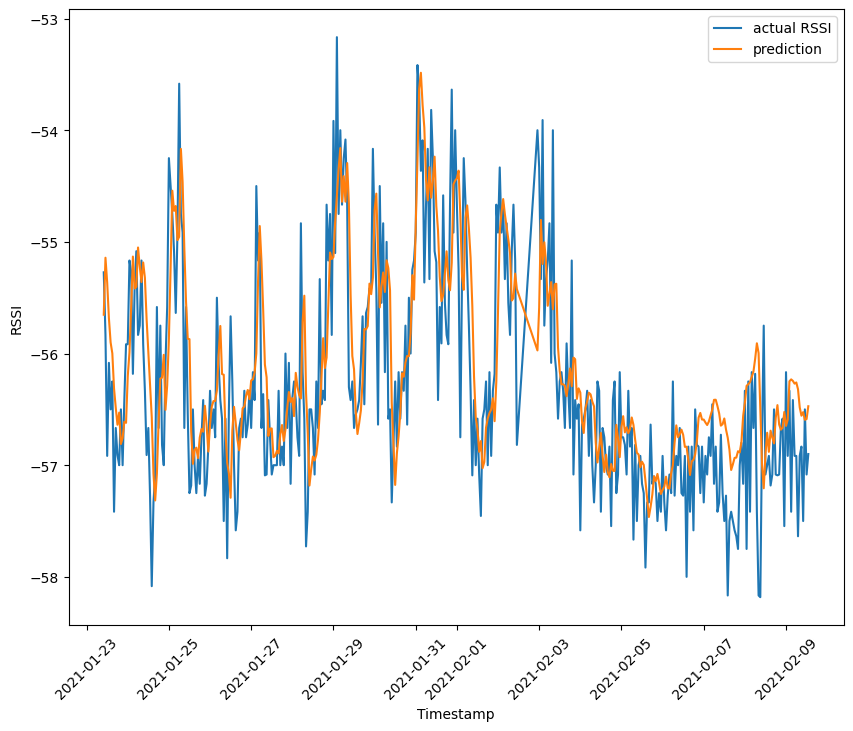

In [ ]:
plt.plot(df_final['rssi_01'], label = "actual RSSI")
plt.plot(df_final['pred'], label = 'prediction')
plt.xticks(rotation=45)
plt.ylabel("RSSI")
plt.xlabel("Timestamp")
plt.legend()
plt.savefig('Actual_vs_pred_climate.png')

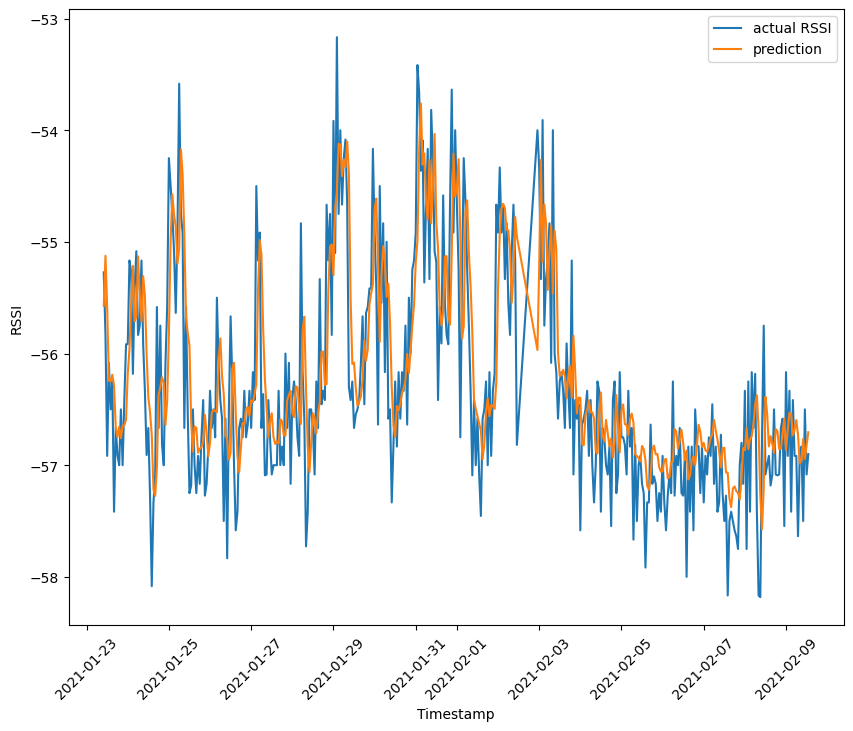

In [ ]:
plt.plot(df_final1['rssi_01'], label = "actual RSSI")
plt.plot(df_final1['pred'], label = 'prediction')
plt.xticks(rotation=45)
plt.ylabel("RSSI")
plt.xlabel("Timestamp")
plt.legend()
plt.savefig('Actual_vs_pred.png')

In [ ]:
#saving model using pickle
import pickle

file_name = 'saved_model.pkl'
pickle.dump(model, open(file_name, 'wb'))